<a href="https://colab.research.google.com/github/ByungjunKim/LODinG_OpenAlex/blob/main/OpenAlex_API_for_Literary_Studies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OpenAlex API for Literary Studies

In [1]:
pip install -U -q requests natsort tqdm

In [2]:
import pandas as pd
import requests
from tqdm.auto import tqdm
tqdm.pandas()
import json
import glob
import time
import re
from natsort import natsorted
import itertools
import matplotlib.pyplot as plt

In [3]:
def request_until_success(url, timeout=25, delay=5):
    """
    Continuously makes a request to the specified URL with a timeout until the request is successful.

    Args:
    - url (str): The URL to request.
    - timeout (int): The timeout for the request in seconds.
    - delay (int): The delay between retries in seconds.

    Returns:
    - response: The successful response from the server.
    """
    attempt = 1
    while True:
        try:
            # print(f"Attempt {attempt}")
            # response = requests.get(url,headers=headers, timeout=timeout)
            response = requests.get(url, timeout=timeout)
            response.raise_for_status()  # Raises HTTPError for bad responses
            # print("Request successful")
            return response.json()
        except requests.Timeout as e:
            print(f"Request timed out: {e}")
        except requests.RequestException as e:
            print(f"Request failed: {e}")

        # print(f"Retrying in {delay} seconds...")
        time.sleep(delay)
        attempt += 1

In [4]:
email = 'kuntakim88@gmail.com'
cursor = '*'

### API

In [5]:
# url with a placeholder for cursor
# example_url_with_cursor = f'https://api.openalex.org/works?filter=title_and_abstract.search:japan,publication_year:2000&per-page=200&cursor={cursor}&mailto={email}'
example_url_with_cursor = f'https://api.openalex.org/works?&filter=primary_topic.subfield.id:subfields/1208&sort=cited_by_count%3Adesc&per-page=200&cursor={cursor}&mailto={email}'

In [6]:
page_with_results = requests.get(example_url_with_cursor).json()

In [7]:
# metadata
page_with_results['meta']

{'count': 2240431,
 'db_response_time_ms': 222,
 'page': None,
 'per_page': 200,
 'next_cursor': 'Ils3NzQsIDEwMC4wLCA3NzQsICdodHRwczovL29wZW5hbGV4Lm9yZy9XMjEzNzUyOTYxMCddIg==',
 'groups_count': None}

In [8]:
# results
page_with_results['results'][0]

{'id': 'https://openalex.org/W1987364024',
 'doi': 'https://doi.org/10.1086/208906',
 'title': 'The Experiential Aspects of Consumption: Consumer Fantasies, Feelings, and Fun',
 'display_name': 'The Experiential Aspects of Consumption: Consumer Fantasies, Feelings, and Fun',
 'publication_year': 1982,
 'publication_date': '1982-09-01',
 'ids': {'openalex': 'https://openalex.org/W1987364024',
  'doi': 'https://doi.org/10.1086/208906',
  'mag': '1987364024'},
 'language': 'en',
 'primary_location': {'is_oa': False,
  'landing_page_url': 'https://doi.org/10.1086/208906',
  'pdf_url': None,
  'source': {'id': 'https://openalex.org/S145429826',
   'display_name': '\x98The \x9cjournal of consumer research/Journal of consumer research',
   'issn_l': '0093-5301',
   'issn': ['0093-5301', '1537-5277'],
   'is_oa': False,
   'is_in_doaj': False,
   'host_organization': 'https://openalex.org/P4310311648',
   'host_organization_name': 'Oxford University Press',
   'host_organization_lineage': ['ht

In [9]:
end = int(page_with_results['meta']['count']/200)+1
start = 0
print(start, end)

0 11203


In [10]:
!mkdir data

In [11]:
for idx in tqdm(range(start,end)[:10]):
    # set cursor value and request page from OpenAlex
    # url = base_url.format(cursor)
    # page_with_results = requests.get(url).json()
    url = f'https://api.openalex.org/works?filter=primary_topic.subfield.id:subfields/1208&sort=cited_by_count%3Adesc&per-page=200&cursor={cursor}&mailto={email}'

    page_with_results = request_until_success(url)

    # json으로 저장
    with open(f'./data/data_{idx}.json','w') as f:
        json.dump(page_with_results,f)
    # next page
    cursor = page_with_results['meta']['next_cursor']

  0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
# json file list
file_list = natsorted(glob.glob('./data/*.json'))
print(len(file_list))
file_list

10


['./data/data_0.json',
 './data/data_1.json',
 './data/data_2.json',
 './data/data_3.json',
 './data/data_4.json',
 './data/data_5.json',
 './data/data_6.json',
 './data/data_7.json',
 './data/data_8.json',
 './data/data_9.json']

In [13]:
# 여러 json 파일을 읽어서 result만 하나의 리스트로 저장하기
openalex_json = []
for file in tqdm(file_list):
    with open(file,'r') as f:
        temp_json = json.load(f)['results']
    openalex_json.extend(temp_json)

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
# pandas dataframe으로 변환
df = pd.DataFrame.from_dict(openalex_json)
df

,id,doi,title,display_name,publication_year,publication_date,ids,language,primary_location,type,...,referenced_works,related_works,ngrams_url,abstract_inverted_index,cited_by_api_url,counts_by_year,updated_date,created_date,datasets,versions
0,https://openalex.org/W1987364024,https://doi.org/10.1086/208906,The Experiential Aspects of Consumption: Consu...,The Experiential Aspects of Consumption: Consu...,1982,1982-09-01,{'openalex': 'https://openalex.org/W1987364024...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,"[https://openalex.org/W73914831, https://opena...","[https://openalex.org/W2748952813, https://ope...",https://api.openalex.org/works/W1987364024/ngrams,"{'This': [0, 50], 'paper': [1], 'argues': [2],...",https://api.openalex.org/works?filter=cites:W1...,"[{'year': 2024, 'cited_by_count': 89}, {'year'...",2024-04-30T13:27:14.489558,2016-06-24,NaN,NaN
1,https://openalex.org/W1831475266,None,"Identity, youth, and crisis","Identity, youth, and crisis",1968,1968-01-01,{'openalex': 'https://openalex.org/W1831475266...,en,"{'is_oa': False, 'landing_page_url': 'http://c...",book,...,[],"[https://openalex.org/W1583489002, https://ope...",https://api.openalex.org/works/W1831475266/ngrams,"{'Identity,': [0], 'Erikson': [1], 'writes,': ...",https://api.openalex.org/works?filter=cites:W1...,"[{'year': 2023, 'cited_by_count': 7}, {'year':...",2024-04-18T07:52:20.259053,2016-06-24,[],[]
2,https://openalex.org/W1945524409,None,Childhood and Society,Childhood and Society,1950,1950-01-01,{'openalex': 'https://openalex.org/W1945524409...,en,"{'is_oa': False, 'landing_page_url': 'http://c...",book,...,[],"[https://openalex.org/W138047100, https://open...",https://api.openalex.org/works/W1945524409/ngrams,"{'The': [0, 133], 'original': [1], 'and': [2, ...",https://api.openalex.org/works?filter=cites:W1...,"[{'year': 2023, 'cited_by_count': 13}, {'year'...",2024-04-18T04:34:04.145827,2016-06-24,[],[]
3,https://openalex.org/W4301357669,https://doi.org/10.1017/cbo9780511620539,Using Language,Using Language,1996,1996-05-16,{'openalex': 'https://openalex.org/W4301357669...,en,"{'is_oa': False, 'landing_page_url': 'https://...",book,...,[],"[https://openalex.org/W2466416226, https://ope...",https://api.openalex.org/works/W4301357669/ngrams,"{'This': [0], 'book,': [1], 'first': [2], 'pub...",https://api.openalex.org/works?filter=cites:W4...,"[{'year': 2024, 'cited_by_count': 51}, {'year'...",2024-05-02T11:18:07.677303,2022-10-05,NaN,NaN
4,https://openalex.org/W4249668278,https://doi.org/10.1206/novi,American Museum Novitates,American Museum Novitates,2019,2019-06-11,{'openalex': 'https://openalex.org/W4249668278...,en,"{'is_oa': False, 'landing_page_url': 'https://...",paratext,...,[],"[https://openalex.org/W2748952813, https://ope...",https://api.openalex.org/works/W4249668278/ngrams,None,https://api.openalex.org/works?filter=cites:W4...,"[{'year': 2024, 'cited_by_count': 16}, {'year'...",2024-04-30T02:41:26.454036,2022-05-12,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,https://openalex.org/W2143785320,https://doi.org/10.1177/0093650209351912,Pathways to Persuasion: Cognitive and Experien...,Pathways to Persuasion: Cognitive and Experien...,2009,2009-12-01,{'openalex': 'https://openalex.org/W2143785320...,en,"{'is_oa': False, 'landing_page_url': 'https://...",article,...,"[https://openalex.org/W125463860, https://open...","[https://openalex.org/W2100413720, https://ope...",https://api.openalex.org/works/W2143785320/ngrams,"{'The': [0], 'experience': [1], 'of': [2, 112,...",https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2024, 'cited_by_count': 3}, {'year':...",2024-04-20T13:14:28.491049,2016-06-24,[],[]
1996,https://openalex.org/W2441325136,https://doi.org/10.2307/2907804,Marxism and Form: Twentieth-Century Dialectica...,Marxism and Form: Twentieth-Century Dialectica...,1972,1972-12-01,{'openalex': 'https://openalex.org/W2441325136...,en,"{'is_oa': Fals

In [15]:
df = df.drop_duplicates(subset=['id']).reset_index(drop=True)
len(df)

2000

In [16]:
def index_to_text(abstract_inverted_index):
    abstract_index = {}
    for k, vlist in abstract_inverted_index.items():
        for v in vlist:
            abstract_index[v] = k
    abstract = ' '.join(abstract_index[k] for k in sorted(abstract_index.keys()))
    return abstract

In [17]:
# index to text
df['abstract'] = df[~pd.isna(df['abstract_inverted_index'])]['abstract_inverted_index'].progress_map(lambda x:index_to_text(x))
df['abstract']

  0%|          | 0/1529 [00:00<?, ?it/s]

0       This paper argues for the recognition of impor...
1       Identity, Erikson writes, is an unfathomable a...
2       The original and vastly influential ideas of E...
3       This book, first published in 1996, argues tha...
4                                                     NaN
                              ...                        
1995    The experience of transportation—being absorbe...
1996                                                  NaN
1997                                                  NaN
1998    Changing dimensions of school literacies learn...
1999                                                  NaN
Name: abstract, Length: 2000, dtype: object

In [18]:
df.columns

Index(['id', 'doi', 'title', 'display_name', 'publication_year',
       'publication_date', 'ids', 'language', 'primary_location', 'type',
       'type_crossref', 'indexed_in', 'open_access', 'authorships',
       'countries_distinct_count', 'institutions_distinct_count',
       'corresponding_author_ids', 'corresponding_institution_ids', 'apc_list',
       'apc_paid', 'has_fulltext', 'fulltext_origin', 'cited_by_count',
       'cited_by_percentile_year', 'biblio', 'is_retracted', 'is_paratext',
       'primary_topic', 'topics', 'keywords', 'concepts', 'mesh',
       'locations_count', 'locations', 'best_oa_location',
       'sustainable_development_goals', 'grants', 'referenced_works_count',
       'referenced_works', 'related_works', 'ngrams_url',
       'abstract_inverted_index', 'cited_by_api_url', 'counts_by_year',
       'updated_date', 'created_date', 'datasets', 'versions', 'abstract'],
      dtype='object')

##### topics

In [19]:
df['topics'][0]

[{'id': 'https://openalex.org/T12214',
  'display_name': 'The Role of Narrative in Persuasive Communication',
  'score': 0.9785,
  'subfield': {'id': 'https://openalex.org/subfields/1208',
   'display_name': 'Literature and Literary Theory'},
  'field': {'id': 'https://openalex.org/fields/12',
   'display_name': 'Arts and Humanities'},
  'domain': {'id': 'https://openalex.org/domains/2',
   'display_name': 'Social Sciences'}},
 {'id': 'https://openalex.org/T14308',
  'display_name': 'The Psychology of Curiosity and Exploration',
  'score': 0.9579,
  'subfield': {'id': 'https://openalex.org/subfields/3205',
   'display_name': 'Experimental and Cognitive Psychology'},
  'field': {'id': 'https://openalex.org/fields/32',
   'display_name': 'Psychology'},
  'domain': {'id': 'https://openalex.org/domains/2',
   'display_name': 'Social Sciences'}},
 {'id': 'https://openalex.org/T11040',
  'display_name': 'Personality Traits and Their Impacts on Life Outcomes',
  'score': 0.9392,
  'subfield':

In [20]:
df['topics_name'] = df['topics'].dropna().progress_map(lambda x:[t['display_name'] for t in x])
df['subfield_name'] = df['topics'].dropna().progress_map(lambda x:[t['subfield']['display_name'] for t in x])
df['field_name'] = df['topics'].dropna().progress_map(lambda x:[t['field']['display_name'] for t in x])
df['domain_name'] = df['topics'].dropna().progress_map(lambda x:[t['domain']['display_name'] for t in x])

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [21]:
df['subfield_name']

0       [Literature and Literary Theory, Experimental ...
1                        [Literature and Literary Theory]
2                        [Literature and Literary Theory]
3       [Literature and Literary Theory, Language and ...
4                        [Literature and Literary Theory]
                              ...                        
1995    [Literature and Literary Theory, Applied Psych...
1996    [Literature and Literary Theory, Philosophy, L...
1997    [Literature and Literary Theory, Language and ...
1998    [Literature and Literary Theory, Speech and He...
1999                     [Literature and Literary Theory]
Name: subfield_name, Length: 2000, dtype: object

In [22]:
df.loc[df['topics_name'].str.len()>0,'topics_name'].map(lambda x:x[0]).value_counts()

topics_name
Discourse Analysis in Academic Writing and Media                  338
English-Medium Instruction in Higher Education                    324
The Role of Narrative in Persuasive Communication                 278
Multimodal Literacy in Education and Society                      130
Children's Literature and its Impact                              120
Postcolonial Literature in Global Context                          88
Adaptation Studies in Literature and Film                          71
Cultural Studies and Critical Theory                               69
The Pervasiveness of Fairy Tales in Culture                        63
Narratology and Fictional Narratives                               60
Modernist Poetry and Literary Criticism                            55
Literature in the Postmodern Era                                   51
Digital Humanities in Literary Studies                             48
Ernest Hemingway's Literary and Cultural Impact                    34
Climate 

##### author

In [23]:
df['authorships'][0]

[{'author_position': 'first',
  'author': {'id': 'https://openalex.org/A5038481372',
   'display_name': 'Morris B. Holbrook',
   'orcid': None},
  'institutions': [{'id': 'https://openalex.org/I880766802',
    'display_name': 'Graduate School USA',
    'ror': 'https://ror.org/04n835f38',
    'country_code': 'US',
    'type': 'education',
    'lineage': ['https://openalex.org/I880766802']}],
  'countries': ['US'],
  'is_corresponding': False,
  'raw_author_name': 'Morris B. Holbrook',
  'raw_affiliation_strings': ['Columbia U Graduate School of Business']},
 {'author_position': 'last',
  'author': {'id': 'https://openalex.org/A5000896034',
   'display_name': 'Elizabeth C. Hirschman',
   'orcid': None},
  'institutions': [],
  'countries': [],
  'is_corresponding': False,
  'raw_author_name': 'Elizabeth C. Hirschman',
  'raw_affiliation_strings': []}]

In [24]:
df['authorships_id'] = df['authorships'].progress_map(lambda x:[a['author']['id'] for a in x])

  0%|          | 0/2000 [00:00<?, ?it/s]

In [25]:
df['authorships_country'] = df['authorships'].progress_map(lambda x:[a['countries'] for a in x])
df['authorships_country'] = df['authorships_country'].progress_map(lambda x:[c[0] if len(c)>0 else None for c in x])
df['authorships_country']

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0         [US, None]
1             [None]
2             [None]
3               [US]
4                 []
            ...     
1995    [US, AU, AU]
1996    [None, None]
1997          [None]
1998          [None]
1999    [None, None]
Name: authorships_country, Length: 2000, dtype: object

In [26]:
pd.Series([x for sublist in df['authorships_country'] for x in sublist if x is not None]).value_counts()

US    736
GB    151
CA     54
AU     44
NL     37
HK     31
ES     24
DE     23
SG     16
CN     15
JP     15
FI     14
KR     13
BE     13
SE     12
BR     10
IL      9
NZ      8
DK      8
FR      7
CH      7
AT      6
NO      5
IE      5
HU      5
ZA      4
MX      4
GH      3
EG      2
IN      2
TH      1
LU      1
BG      1
TW      1
PL      1
PH      1
SI      1
TR      1
BW      1
VN      1
ER      1
MO      1
Name: count, dtype: int64

In [27]:
authorship_id = df['authorships'].progress_map(lambda x:[a['author']['id'] for a in x]).tolist()
authorship_id = list(set(list(itertools.chain(*authorship_id))))

  0%|          | 0/2000 [00:00<?, ?it/s]

In [28]:
!mkdir ./data/author

In [29]:
for id in tqdm(authorship_id):
    id = id.split('/')[-1]
    url = f'https://api.openalex.org/authors/{id}&mailto=kuntakim88@gmail.com'
    page_with_results = request_until_success(url)
    # json으로 저장
    with open(f'./data/author/{id}.json','w') as f:
            json.dump(page_with_results,f)

  0%|          | 0/2470 [00:00<?, ?it/s]

In [30]:
author_file_list = glob.glob('./data/author/*.json')
len(author_file_list)

2470

In [31]:
openalex_author_json = []
for file in tqdm(author_file_list):
    with open(file,'r') as f:
        temp_json = json.load(f)
    openalex_author_json.append(temp_json)

  0%|          | 0/2470 [00:00<?, ?it/s]

In [32]:
df_author = pd.DataFrame(openalex_author_json)
df_author

,id,orcid,display_name,display_name_alternatives,works_count,cited_by_count,summary_stats,ids,affiliations,last_known_institutions,topics,topic_share,x_concepts,counts_by_year,works_api_url,updated_date,created_date
0,https://openalex.org/A5066836457,https://orcid.org/0000-0002-5936-3901,Hossein Nassaji,"[H Nassaji, Hossein Nassaji]",132,5479,"{'2yr_mean_citedness': 2.4, 'h_index': 36, 'i1...",{'openalex': 'https://openalex.org/A5066836457...,[{'institution': {'id': 'https://openalex.org/...,"[{'id': 'https://openalex.org/I212119943', 'ro...","[{'id': 'https://openalex.org/T10021', 'displa...","[{'id': 'https://openalex.org/T10021', 'displa...","[{'id': 'https://openalex.org/C138885662', 'wi...","[{'year': 2024, 'works_count': 2, 'cited_by_co...",https://api.openalex.org/works?filter=author.i...,2024-05-02T02:33:26.592705,2023-07-21
1,https://openalex.org/A5020070146,None,Jennifer P. Read,"[Jennifer P. Read, J. P. Read, Jennifer Parson...",213,11588,"{'2yr_mean_citedness': 2.0, 'h_index': 50, 'i1...",{'openalex': 'https://openalex.org/A5020070146'},[{'institution': {'id': 'https://openalex.org/...,"[{'id': 'https://openalex.org/I63190737', 'ror...","[{'id': 'https://openalex.org/T10043', 'displa...","[{'id': 'https://openalex.org/T10043', 'displa...","[{'id': 'https://openalex.org/C15744967', 'wik...","[{'year': 2024, 'works_count': 6, 'cited_by_co...",https://api.openalex.org/works?filter=author.i...,2024-05-01T07:36:37.502777,2023-07-21
2,https://openalex.org/A5068617096,None,Shalini Misra,"[S. Misra, Shalini Misra, S. P. Misra]",43,1536,"{'2yr_mean_citedness': 1.0, 'h_index': 12, 'i1...",{'openalex': 'https://openalex.org/A5068617096'},[{'institution': {'id': 'https://openalex.org/...,"[{'id': 'https://openalex.org/I859038795', 'ro...","[{'id': 'https://openalex.org/T12766', 'displa...","[{'id': 'https://openalex.org/T12766', 'displa...","[{'id': 'https://openalex.org/C17744445', 'wik...","[{'year': 2024, 'works_count': 0, 'cited_by_co...",https://api.openalex.org/works?filter=author.i...,2024-04-30T07:21:53.563816,2023-07-21
3,https://openalex.org/A5052452483,None,David E. Nye,"[Dr Nye, D. Nye, David Nye, Donald Nye, David ...",217,1851,"{'2yr_mean_citedness': 0.0, 'h_index': 13, 'i1...",{'openalex': 'https://openalex.org/A5052452483'},[{'institution': {'id': 'https://openalex.org/...,"[{'id': 'https://openalex.org/I2801851002', 'r...","[{'id': 'https://openalex.org/T12837', 'displa...","[{'id': 'https://openalex.org/T13308', 'displa...","[{'id': 'https://openalex.org/C95457728', 'wik...","[{'year': 2024, 'works_count': 1, 'cited_by_co...",https://api.openalex.org/works?filter=author.i...,2024-04-28T16:31:47.369699,2023-07-21
4,https://openalex.org/A5051863081,None,Patricia A. Duff,"[Putu Duff, Patricia Duff, Patricia Ann Duff, ...",194,7874,"{'2yr_mean_citedness': 4.142857142857143, 'h_i...",{'openalex': 'https://openalex.org/A5051863081'},[{'institution': {'id': 'https://openalex.org/...,"[{'id': 'https://openalex.org/I141945490', 'ro...","[{'id': 'https://openalex.org/T10265', 'displa...","[{'id': 'https://openalex.org/T11350', 'displa...","[{'id': 'https://openalex.org/C144024400', 'wi...","[{'year': 2024, 'works_count': 2, 'cited_by_co...",https://api.openalex.org/works?filter=author.i...,2024-04-30T09:00:26.116852,2023-07-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2465,https://openalex.org/A5029389577,None,John Feather,"[John P. Feather, John Norman Feather, John Fe...",223,3801,"{'2yr_mean_citedness': 0.0, 'h_index': 22, 'i1...",{'openalex': 'https://openalex.org/A5029389577'},[{'institution': {'id': 'https://openalex.org/...,"[{'id': 'https://openalex.org/I143804889', 'ro...","[{'id': 'https://openalex.org/T12289', 'displa...","[{'id': 'https://openalex.org/T13066', 'displa...","[{'id': 'https://openalex.org/C41008148', 'wik...","[{'year': 2024, 'works_count': 0, 'cited_by_co...",https://api.openalex.org/works?filter=author.i...,2024-05-01T23:54:58.760131,2023-07-21
2466,https://open

In [33]:
# df_author['country_code'] = df_author.loc[df_author['last_known_institutions'].str.len()!=0,'last_known_institutions'].progress_map(lambda x:x[0]['country_code'])

In [34]:
# df_author['country_code'].value_counts()

In [35]:
# # no country code
# pd.isna(df_author['country_code']).sum()

In [36]:
# author_country = df_author[['id','country_code']].to_dict(orient='records')
# author_country = [d for d in author_country if d['country_code'] == d['country_code']]

In [37]:
# # authorships_id match to country_code
# def get_country_codes(author_ids):
#     country_codes = []
#     for author_id in author_ids:
#         country_code = next((d['country_code'] for d in author_country if d['id'] == author_id), None)
#         country_codes.append(country_code)
#     return country_codes

In [38]:
# df['country_code'] = df['authorships_id'].apply(get_country_codes)

In [39]:
# df['country_code'] = df['country_code'].apply(lambda lst: [x for x in lst if x is not None])

In [40]:
# country_code 리스트를 행으로 확장
df_exploded = df.explode('authorships_country')

# origin 및 country_code 별로 그룹화하여 출현 횟수 계산
count_per_origin_country = df_exploded.groupby(['authorships_country']).size().reset_index(name='count')

# 빈 country_code 제거
df_exploded = df_exploded[df_exploded['authorships_country'].notna()]

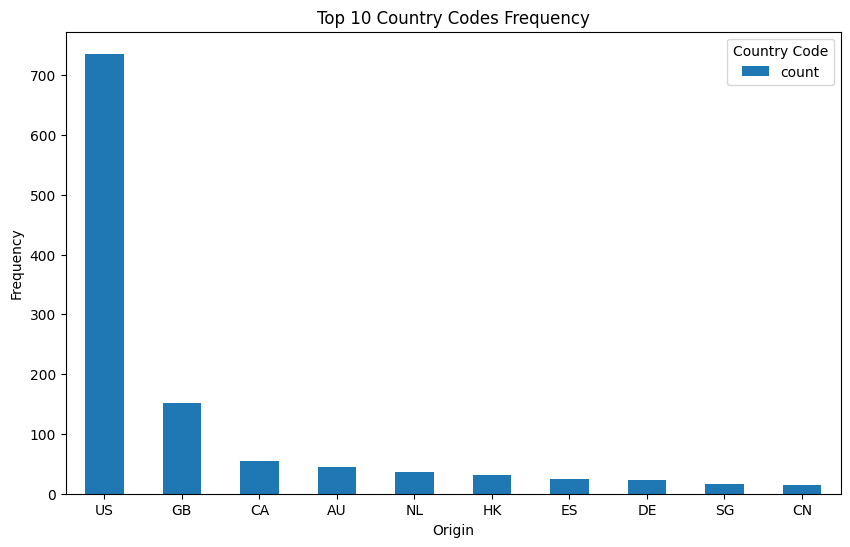

In [41]:
# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

# 각 origin 유형별로 상위 10개 country_code의 빈도를 막대 그래프로 시각화
counts = df_exploded['authorships_country'].value_counts()
counts.nlargest(10).plot(kind='bar', ax=ax)

# 축 이름 및 타이틀 설정
ax.set_xlabel('Origin')
ax.set_ylabel('Frequency')
ax.set_title('Top 10 Country Codes Frequency')

# 범례 설정
ax.legend(title='Country Code')

# 그래프 표시
plt.xticks(rotation=0)  # x축 라벨 회전 설정
plt.show()